## Семинар 9: "LSTM"

ФИО: Висков Василий

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn.utils.rnn import pack_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.FloatTensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.FloatTensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.FloatTensor(self.gate_size).zero_())

    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)

        seq_length = inputs.size(0)
        out = Variable(torch.FloatTensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
            
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

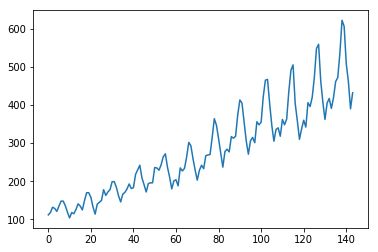

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test

border = 0.67
train_size = int(len(dataset) * border)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

96 48


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1 - look_forward):
        a = dataset[i:i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back:i + look_back + look_forward, 0])

    return np.array(dataX), np.array(dataY)

In [7]:
# Пример подготовленных данных

look_back = 35
look_forward = 1

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
train_dataset = TensorDataset(torch.from_numpy(trainX),
                              torch.from_numpy(trainY))
train_dataloader = DataLoader(train_dataset, shuffle=True,
                              batch_size=48)

## Torch

In [9]:
class pyLSTM(nn.Module):
    def __init__(self, hidden_dim, num_layers=1):
        super(pyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)

        self.linear = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(1)
        batch_size = inp.size(0)
        hidden = (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)),
                  Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)))
        inp = pack_sequence(inp)
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out, _ = pad_packed_sequence(lstm_out, False)

        lstm_out = lstm_out[-1]

        out = self.linear(lstm_out.view(batch_size, self.hidden_dim))
        return out

In [10]:
py_lstm = pyLSTM(10)

In [11]:
optimizer = torch.optim.Adam(py_lstm.parameters(), lr=1e-2)
scheduler = StepLR(optimizer, 1)

In [12]:
n_epochs = 1000
loss_f = nn.MSELoss()
losses = list()
for reduce in range(3):
    for epoch in range(n_epochs):
        losses = []
        for X, Y in train_dataloader:
            py_lstm.zero_grad()
            X = Variable(torch.FloatTensor(X)).view(-1, look_back, 1)
            Y = Variable(torch.FloatTensor(Y)).view(-1, 1)
            p = py_lstm(X)
            loss = loss_f(p, Y)
            losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
        if epoch % 500 == 0:
            print("reduce: {}, loss: {:.3e}".format(reduce, np.mean(losses)))
    scheduler.step()

reduce: 0, loss: 4.679e-02
reduce: 0, loss: 3.443e-04
reduce: 1, loss: 7.488e-05
reduce: 1, loss: 4.071e-05
reduce: 2, loss: 2.217e-05
reduce: 2, loss: 2.159e-05


In [13]:
def generate(model, n, inputs, batch_first=True):
    result = np.zeros(n + len(inputs))
    result[:len(inputs)] = inputs
    inp = 0
    for i in range(n):
        if batch_first:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(1, len(inputs), 1)
        else:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(len(inputs), 1, 1)
        res = model(inp)
        result[i + len(inputs)] = res[-1].data.numpy()
    return result

total loss: 0.05473166517191357


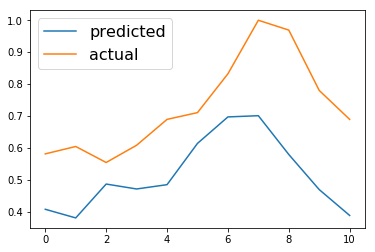

In [14]:
base = testX[:, 0]
predicted = generate(py_lstm, 0, base)
actual = testY[:, 0]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)
print("total loss:", sum((predicted - actual) ** 2) / len(predicted))
plt.show()

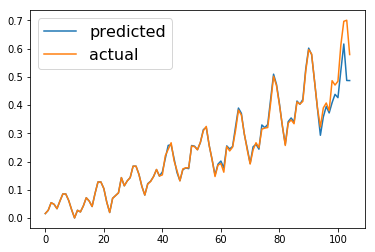

In [15]:
seq = dataset[:,0]
start = 0
plength = 70
blength = 35
base =  seq[start:start+blength]
predicted = generate(py_lstm, plength, base)
actual = seq[start:start+plength+blength]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)
plt.show()

## Реализация

In [16]:
class myLSTM(nn.Module):    
    def __init__(self, hidden_dim):
        super(myLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = LSTM(1, hidden_dim)

        self.linear = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(0)
        batch_size = inp.size(1)
        hidden = (Variable(torch.zeros(batch_size, self.hidden_dim)),
                  Variable(torch.zeros(batch_size, self.hidden_dim)))
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out = lstm_out[-1]
        out = self.linear(lstm_out.view(batch_size, self.hidden_dim))
        return out


In [17]:
my_lstm = myLSTM(10)

In [18]:
optimizer = torch.optim.Adam(my_lstm.parameters(), lr=1e-1)
scheduler = StepLR(optimizer, 1)

In [19]:
n_epochs = 1500
loss_f = nn.MSELoss()
losses = list()
for reduce in range(3):
    for epoch in range(n_epochs):
        losses = []
        for X, Y in train_dataloader:
            my_lstm.zero_grad()
            X = Variable(X.permute(1, 0).unsqueeze(-1))
            Y = Variable(Y)
            p = my_lstm(X)
            loss = loss_f(p, Y)
            losses.append(loss.data.item())
            loss.backward()
            optimizer.step()
        if epoch % 500 == 0:
            print("reduce: {}, loss: {:.3e}".format(reduce, np.mean(losses)))
    scheduler.step()

reduce: 0, loss: 2.059e-02
reduce: 0, loss: 1.791e-03
reduce: 0, loss: 4.138e-04
reduce: 1, loss: 1.903e-04
reduce: 1, loss: 4.111e-06
reduce: 1, loss: 2.549e-06
reduce: 2, loss: 1.354e-06
reduce: 2, loss: 4.754e-07
reduce: 2, loss: 3.598e-07


total loss: 0.05473166517191357


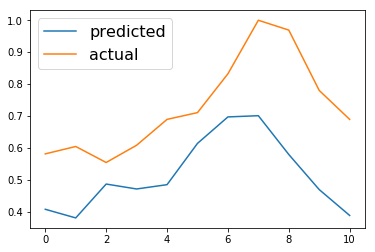

In [20]:
base =  testX[:, 0]
predicted = generate(my_lstm, 0, base)
actual = testY[:, 0]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)
print("total loss:", sum((predicted - actual) ** 2) / len(predicted))
plt.show()

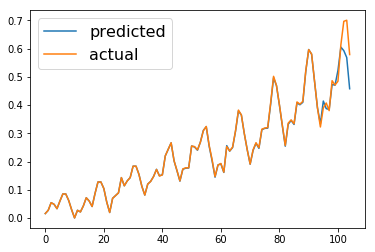

In [21]:
seq = dataset[:, 0]
start = 0
plength = 70
blength = 35
base =  seq[start:start+blength]
predicted = generate(my_lstm, plength, base, batch_first=False)
actual = seq[start:start+plength+blength]
plt.plot(predicted, label='predicted')
plt.plot(actual, label='actual')
plt.legend(fontsize=16)
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: